# Analyze Results

In [169]:
import chess
import matplotlib.pyplot as plt
import pandas as pd
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

SAMPLE_ELOS = [800, 1000, 1200, 1500, 1800, 2000, 2200]

In [170]:
df = pd.read_parquet("../data/stats_dataset.parquet")
df.tail()

,fen,next_move,games_count,global_avg_elo,global_winrate,engine_move,delta,fragility_score,variance,group_count_800,...,is_engine_top3_2000,group_count_2200,winrate_2200,score_2200,recommended_move_2200,historical_best_2200,is_best_2200,is_engine_best_2200,is_top3_2200,is_engine_top3_2200
265,rnbqkb1r/pp2pp1p/5np1/3p2B1/3P4/2N2N2/PPP2PPP/...,f8g7,104,1678.096154,0.451923,b8c6,0.116353,0.048808,-0.428462,4.0,...,<NA>,31,0.451613,-0.156054,f8g7,f8g7,True,<NA>,True,<NA>
266,rnbqkb1r/pp3ppp/4pn2/1B1p4/3P4/2N2N2/PPP2PPP/R...,c8d7,110,1599.345455,0.518182,c8d7,0.366785,0.667710,-0.324725,8.0,...,True,23,0.521739,0.021030,c8d7,c8d7,True,True,True,True
267,rnbqkb1r/pp3ppp/4pn2/3p2B1/3P4/2N2N2/PPP2PPP/R...,f8e7,210,1564.290476,0.485714,b8c6,0.295233,0.063857,-0.464949,11.0,...,<NA>,21,0.619048,-0.084858,f8e7,f8e7,True,<NA>,True,<NA>
268,rnbqkb1r/pp3ppp/4pn2/3p2B1/3P4/2N2N2/PPP2PPP/R...,f8e7,102,1590.254902,0.480392,b8c6,0.259457,0.063857,-0.446934,4.0,...,<NA>,15,0.333333,-0.093739,f8e7,f8e7,<NA>,<NA>,<NA>,<NA>
269,rnbqkbnr/pp3ppp/4p3/3pP3/3P4/5N2/PP3PPP/RNBQKB...,b8c6,103,1590.407767,0.466019,b8c6,0.116353,-0.760091,-0.446039,9.0,...,True,14,0.500000,-0.164843,b8c6,b8c6,<NA>,<NA>,<NA>,<NA>


## Prediction accuracy

In [171]:
results = []
grouped = df.groupby("fen").first().reset_index()


def weighted_mean(values, weights):
    mask = values.notna() & weights.notna()
    if mask.sum() == 0:
        return float("nan")
    return (values[mask] * weights[mask]).sum() / weights[mask].sum()


for elo in SAMPLE_ELOS:
    is_best_col = f"is_best_{elo}"
    is_engine_col = f"is_engine_best_{elo}"
    is_top3_col = f"is_top3_{elo}"
    is_engine_top3_col = f"is_engine_top3_{elo}"
    group_count_col = f"group_count_{elo}"

    weighted_avg_is_best = weighted_mean(grouped[is_best_col], grouped[group_count_col])
    weighted_avg_is_engine_best = weighted_mean(grouped[is_engine_col], grouped[group_count_col])
    weighted_avg_is_top3_best = weighted_mean(grouped[is_top3_col], grouped[group_count_col])
    weighted_avg_is_engine_top3_best = weighted_mean(grouped[is_engine_top3_col], grouped[group_count_col])

    results.append({
        "elo": elo,
        "avg_is_best": weighted_avg_is_best,
        "avg_is_engine_best": weighted_avg_is_engine_best,
        "avg_is_top3": weighted_avg_is_top3_best,
        "avg_is_engine_top3": weighted_avg_is_engine_top3_best
    })

results = pd.DataFrame(results)
results

,elo,avg_is_best,avg_is_engine_best,avg_is_top3,avg_is_engine_top3
0,800,0.449541,0.394495,1.0,1.000000
1,1000,0.869341,0.731795,1.0,0.994232
2,1200,0.877397,0.801992,1.0,1.000000
3,1500,0.829339,0.820420,1.0,1.000000
4,1800,0.851575,0.847505,1.0,0.988642
5,2000,0.863831,0.880187,1.0,0.983434
6,2200,0.911217,0.902036,1.0,0.978690


## Sample position

In [172]:
random_fen = df["fen"].sample(1).iloc[0]
filtered = df[df["fen"] == random_fen]
filtered.drop("fen", axis=1).set_index('next_move').T

next_move,e2f3
games_count,172
global_avg_elo,1538.55814
global_winrate,0.366279
engine_move,e2f3
delta,0.509889
...,...
historical_best_2200,e2f3
is_best_2200,<NA>
is_engine_best_2200,<NA>
is_top3_2200,<NA>


In [173]:
print(random_fen)

rn1qkbnr/pp3ppp/4p3/3p4/3P4/5b1P/PPP1BPP1/RNBQK2R w KQkq - 0 7


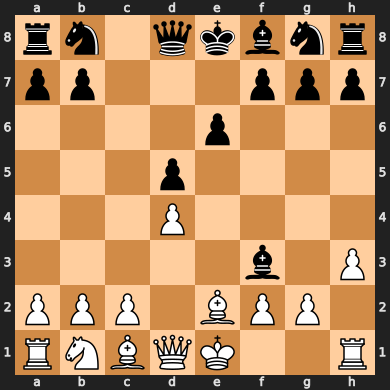

In [174]:
chess.Board(random_fen)

## Evaluate with Regression and XGBoost

In [175]:
df["f_cross_d"] = df["fragility_score"] * df["delta"]
df["f_cross_v"] = df["fragility_score"] * df["variance"]
df["d_cross_v"] = df["delta"] * df["variance"]

y_feature = "is_best_1200"
df_reg = df[pd.notna(df[y_feature])]

selected_features = ["fragility_score", "delta", "variance", "f_cross_d", "f_cross_v", "d_cross_v"]
X = df_reg[selected_features]
y = df_reg[y_feature].astype(bool)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=1, stratify=y
)

In [176]:
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
acc_log = accuracy_score(y_test, y_pred_log)
print(f"Logistic Regression Accuracy: {acc_log * 100:.1f} %")

Logistic Regression Accuracy: 80.7 %


In [177]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {acc_xgb * 100:.1f} %")

XGBoost Accuracy: 77.2 %


In [178]:
print("Logistic Regression Coefficients:")
for feature, coef in zip(selected_features, log_model.coef_[0]):
    print(f"{feature}: {coef:.3f}")

Logistic Regression Coefficients:
fragility_score: -0.101
delta: 0.125
variance: -0.106
f_cross_d: -0.086
f_cross_v: 0.133
d_cross_v: 0.067


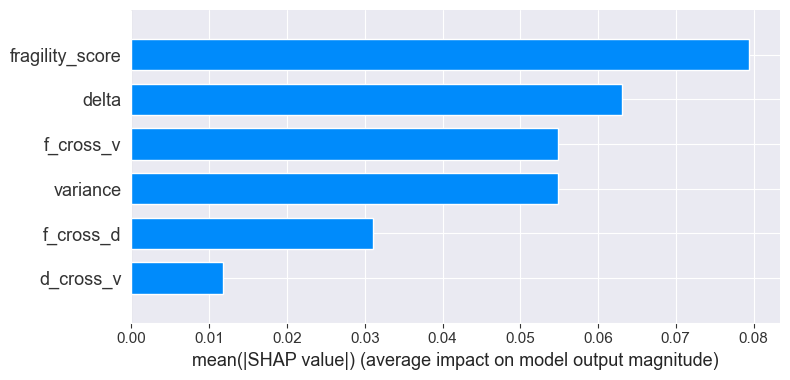

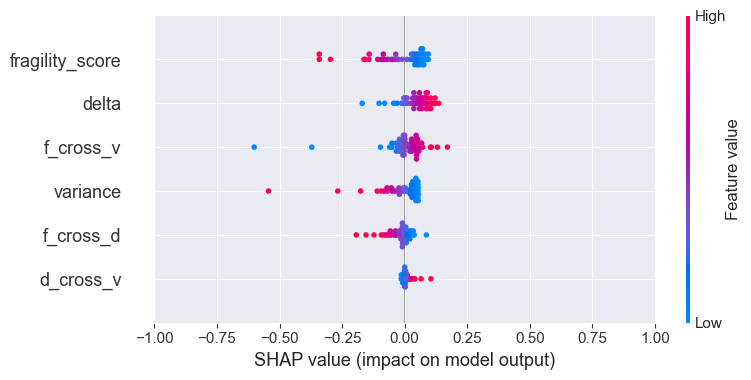

In [179]:
explainer_log = shap.Explainer(log_model, X_train)
shap_values_log = explainer_log(X_test)
shap.summary_plot(shap_values_log, features=X_test, feature_names=selected_features, plot_type="bar")
shap.summary_plot(shap_values_log, features=X_test, feature_names=selected_features, show=False)
plt.xlim(-1, 1)
plt.show()